# Computational Medical Imaging Part 1 - X-Ray Imaging Fundamentals

#### Recommended Prerequisites:

*   1 semester of Radiation Safety
*   1 semester of Nuclear Instrumentation
*   1 (concurrent) semester of Medical Imaging
*   Basic programming

This notebook is part of a series of notebooks exploring the physics of medical imaging. It walks through derivations of mathematical models, example code implementations, and discussions of results. Currently, 6 sections are planned:

1.   X-Ray Imaging Fundamentals
2.   Computed Tomography (CT)
3.   Magnetic Resonance Imaging (MRI)
4.   Ultrasound Imaging
5.   Nuclear Medicine (PET/SPECT)
6.   Image Quality and Optimization

# X-Ray Imaging Fundamentals

## Exponential Attenuation

Photons are attenuated exponentially through matter. This means that for every increment of depth $\Delta x$ penetrated by a beam of many photons, a constant fraction $\mu$ (per unit path length) of those photons are removed. There are multiple ways to express the quantity of photons in the beam at a depth $x$, but for simplicity we can just use the actual number of photons, $N(x)$. The number of photons lost over that increment of distance is $\Delta N = N(x) - N(x + \Delta x)$.

$$\frac{\Delta N}{N(x)} = \frac{N(x) - N(x + \Delta x)}{N(x)} = \mu \Delta x$$

This is the phenomenological description of the Beer-Lambert law. Notice that we can rearrange the equation and apply the definition of the derivative to obtain a first-order ordinary differential equation (ODE).

$$- \frac{N(x + \Delta x) - N(x)}{\Delta x} = \mu N(x)$$

$$\lim_{x\to0} \frac{N(x + \Delta x) - N(x)}{\Delta x} = \frac{dN(x)}{dx}$$

$$- \frac{dN(x)}{dx} = \mu N(x)$$

The solution is an exponential decay function in $x$:

$$\int_{N(0)}^{N(x)} \frac{1}{N(x)} dN(x) = - \int_{0}^{x} \mu dx$$

$$\ln \Bigl( \frac{N(x)}{N(0)} \Bigr) = - \mu x$$

$$\frac{N(x)}{N(0)} = e^{-\mu x}$$

$$N(x) = N(0) e^{-\mu x}$$

Let's use a simple numerical technique for integrating differential equations, called Euler's method, with a finite difference $\Delta x$ of diminishing size to show this.

Euler's method:

$$N(x + \Delta x) = N(x) + \frac{dN(x)}{dx} \cdot \Delta x$$

Assume the beam of photons is monoenergetic at $100 \;\text{keV}$. At this energy, the linear attenuation coefficient of photons in water is about $0.167 \;\text{cm}^{-1}$.

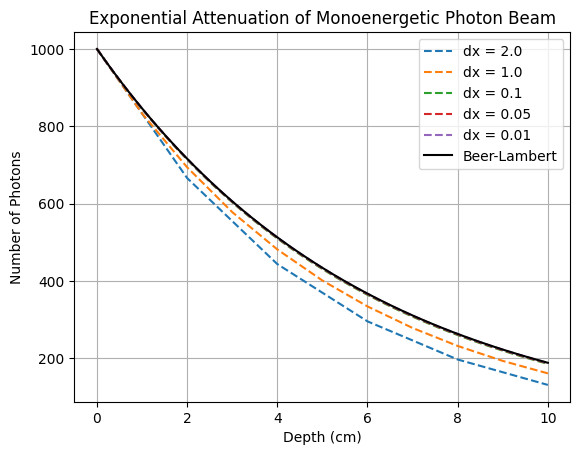

In [81]:
import numpy as np
import matplotlib.pyplot as plt

dx_vals = [2.0, 1.0, 0.1, 0.05, 0.01] # cm
N0 = 1000
x0 = 0 # cm
L = 10 # cm depth
mu = 0.167 # 1/cm linear attenuation coefficient of water for 140 keV photons

def beerlambert(N0, x0, L, dx, mu):
    nsteps = int(L / dx)
    x = x0
    N = N0
    x_data = [x]
    N_data = [N]
    for i in range(nsteps):
        x += dx
        dN = -N * mu * dx
        N += dN
        x_data.append(x)
        N_data.append(N)
    return x_data, N_data

plt.figure()
for dx in dx_vals:
    x_data, N_data = beerlambert(N0, x0, L, dx, mu)
    plt.plot(x_data, N_data, ls="--", label=f"dx = {dx}")

x = np.linspace(x0, L, 1000)
N = N0 * np.exp(-mu*x)
plt.plot(x, N, color="black", label="Beer-Lambert")
plt.xlabel("Depth (cm)")
plt.ylabel("Number of Photons")
plt.title("Exponential Attenuation of Monoenergetic Photon Beam")
plt.grid()
plt.legend()
plt.show()

Note: another way to express the amount of radiation present at a position in space is with the quantity called **intensity** ($I(x)$). In SI units, intensity is $\frac{\text{particles}}{\text{cm}^{2} \;\cdot\; \text{s}}$.

## X-Ray Spectra

In reality, photon beams produced by X-ray generators are polyenergetic, rather than monoenergetic$-$they are non-uniformly distributed over a spectrum of energies.

Let's make a synthetic X-ray spectrum and see how much of the beam gets attenuated at each energy over the penetration depth. The following values were visually estimated from [this figure](https://prod-images-static.radiopaedia.org/images/63492887/3cf7de692faa345643d659961f424a9b59209684019dae1550de93049ba465a7_big_gallery.jpeg) on Radiopaedia, a useful reference website. Consider this "data" merely a toy model for educational purposes, and do not use it for practical calculations. You will see features in the spectrum that can help identify its source.

***Note:*** *"kVp" stands for "kilovolt-peak", and it refers to the greatest ("peak") photon energy found in the spectrum. This is equal to the energy to which electrons are accelerated by the X-ray generator before interacting with the anode. Realistically, only a tiny minority of beam photons will actually carry 100% of any given electron's energy, so the intensity of this component is nearly zero.*

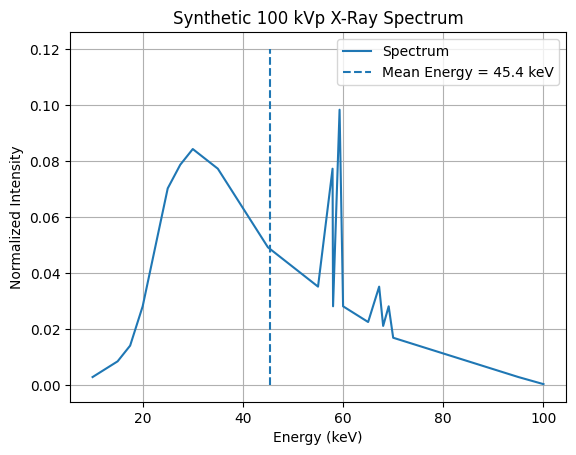

In [82]:
# normalized intensities eyeballed from radiopaedia
synthetic_spectrum = {
    10: 0.001,
    15: 0.003,
    17.5: 0.005,
    20: 0.01,
    22.5: 0.0175,
    25: 0.025,
    27.5: 0.028,
    30: 0.03,
    35: 0.0275,
    40: 0.0225,
    45: 0.0175,
    50: 0.015,
    55: 0.0125,
    57.9: 0.0275, # Tungsten characteristic X-ray
    58: 0.01,
    59.3: 0.035, # Tungsten characteristic X-ray
    60: 0.01,
    65: 0.008,
    67.2: 0.0125, # Tungsten characteristic X-ray
    68: 0.0075,
    69.1: 0.01, # Tungsten characteristic X-ray
    70: 0.006,
    75: 0.005,
    80: 0.004,
    85: 0.003,
    90: 0.002,
    95: 0.001,
    100: 0.0001
}
# re-normalize the intensities
total_intensity = sum(list(synthetic_spectrum.values()))
synthetic_spectrum = {energy: intensity / total_intensity for energy, intensity in synthetic_spectrum.items()}

energies = list(synthetic_spectrum.keys())
intensities = list(synthetic_spectrum.values())

# what's the intensity-weighted mean energy?
initial_mean_energy = np.average(energies, weights=intensities)

plt.figure()
plt.plot(energies, intensities, label="Spectrum")
plt.vlines(initial_mean_energy, 0, 0.12, label=f"Mean Energy = {round(initial_mean_energy,1)} keV", ls="--")
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Intensity")
plt.title("Synthetic 100 kVp X-Ray Spectrum")
plt.grid()
plt.legend()
#plt.yscale('log')
plt.show()

### Spectrum Features

Nice. What do you notice about this spectrum?

For the most part, the energy distribution appears "continuous" (letting go of the fact that computational methods are inherently discrete). This continuous base spectrum is due to ***bremsstrahlung***: the continuous radiative losses of electron kinetic energy by Coulomb interactions with atomic nuclei (and, to a lesser extent, atomic electrons).

However, there are also spikes at $57.9$, $59.3$, $67.2$, and $69.1 \;\text{keV}$. These are from ***characteristic X-rays*** emitted by **tungsten** electrons transitioning into inner orbitals to fill vacancies left by other electrons, which are ejected following photoelectric absorption of X-rays from the anode. The discrete peaks correspond to the differences in binding energies between orbitals. The presence of these specific characteristic X-ray energies tells us that the anode is made of tungsten. In contrast, the lack of very low energies tells us that the beam has been filtered, likely by aluminum.

### Mean Photon Energy

Also note that the mean photon energy is approximately (below) half the kVp. As a rule of thumb, you can generally guess that the mean photon energy in a *diagnostic* (imaging) X-ray beam is about $\frac{1}{3}$ to $\frac{1}{2}$ the maximum (kVp) energy.

## Polyenergetic Attenuation

### Attenuation Data

Now, to properly simulate the evolution of this spectrum throughout penetration of some water-like medium (i.e., tissue), we need a corresponding spectrum of attenuation coefficients. In X-ray imaging, it's important to distinguish between attenuation by photoelectric absorption, which gives clean contrast, and attenuation by incoherent (Compton) scattering, which can contribute to noise in the image. We can obtain attenuation coefficient data from NIST for both of these interactions via the [XCOM database](https://physics.nist.gov/cgi-bin/Xcom/xcom2?Method=Comp&Output2=Hand).

In [83]:
xcom_data = [
    # Energy (MeV), Compton Scatter Coefficient (cm2/g), Photoelectric Coefficient (cm2/g)
    (1.000E-02, 1.550E-01, 4.944E+00),
    (1.500E-02, 1.699E-01, 1.369E+00),
    (2.000E-02, 1.774E-01, 5.439E-01),
    (3.000E-02, 1.829E-01, 1.458E-01),
    (4.000E-02, 1.827E-01, 5.680E-02),
    (5.000E-02, 1.803E-01, 2.725E-02),
    (6.000E-02, 1.770E-01, 1.493E-02),
    (8.000E-02, 1.697E-01, 5.770E-03),
    (1.000E-01, 1.626E-01, 2.763E-03)
] # for water, these are equivalent to 1/cm units

for line in xcom_data:
    print(line)

(0.01, 0.155, 4.944)
(0.015, 0.1699, 1.369)
(0.02, 0.1774, 0.5439)
(0.03, 0.1829, 0.1458)
(0.04, 0.1827, 0.0568)
(0.05, 0.1803, 0.02725)
(0.06, 0.177, 0.01493)
(0.08, 0.1697, 0.00577)
(0.1, 0.1626, 0.002763)


In [84]:
# here's a neat trick: if you have a list of N n-tuples (i.e., N groups of n elements) you can use zip(*<listname>) to turn it into a list of n N-tuples (i.e., n groups of N elements). in this case, we can "unzip" our XCOM data from 9 3-tuples to 3 9-tuples, i.e., a tuple of energies, a tuple of scatter coefficients, and a tuple of photoelectric coefficients
xcom_energies, xcom_CS, xcom_PE = zip(*xcom_data)

# convert xcom energies to keV
xcom_energies = [e*1000 for e in xcom_energies]

print(xcom_energies)
print(xcom_CS)
print(xcom_PE)

[10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0]
(0.155, 0.1699, 0.1774, 0.1829, 0.1827, 0.1803, 0.177, 0.1697, 0.1626)
(4.944, 1.369, 0.5439, 0.1458, 0.0568, 0.02725, 0.01493, 0.00577, 0.002763)


This table from XCOM is incomplete, so to get attenuation coefficients for the missing energies, we need to perform **linear interpolation** between the points we do have.

To interpolate a value $\mu_{i}$ at energy $E_{i}$, if we have values $\mu_{i-1}$ and $\mu_{i+1}$ for a lower energy $E_{i-1}$ and a higher energy $E_{i+1}$, we can use the following formula:

$$\mu_{i} \approx \mu_{i-1} + (\mu_{i+1} - \mu_{i-1}) \frac{E_{i} - E_{i-1}}{E_{i+1} - E_{i-1}}$$

In [85]:
# photoelectric effect attenuation coefficients
mu_PE = {xcom_energy: mu for xcom_energy, mu in zip(xcom_energies, xcom_PE)}
# compton scatter attenuation coefficients
mu_CS = {xcom_energy: mu for xcom_energy, mu in zip(xcom_energies, xcom_CS)}

# which energies are missing?
missing = []
for energy in synthetic_spectrum.keys():
    if energy not in xcom_energies:
        missing.append(energy)
print("Missing (keV):\n", missing)

Missing (keV):
 [17.5, 22.5, 25, 27.5, 35, 45, 55, 57.9, 58, 59.3, 65, 67.2, 68, 69.1, 70, 75, 85, 90, 95]


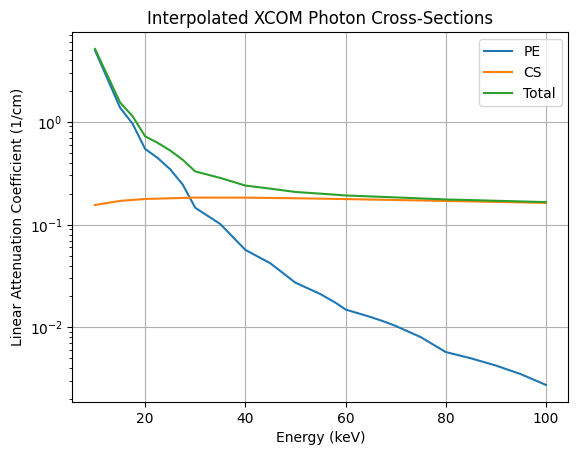

In [86]:
# interpolate values for the attenuation coefficients at some photon energy from XCOM data
# since we know that all the energies in this particular synthetic spectrum are within the range of values we got from XCOM this time, let's ignore "edge cases". this is bad behavior and you shouldn't do it, but alas, we are scientists. feel free to implement them if you want!
# returns: (mu_PE, mu_CS)
def interpolate_energy(energy):
    # find the nearest two energies
    for i, xcom_energy in enumerate(xcom_energies):
        if xcom_energy > energy:
            # found the first energy greater than our target energy!
            # get the coefficients for this energy and the previous energy
            mu_PE_hi, mu_CS_hi = xcom_PE[i], xcom_CS[i]
            mu_PE_lo, mu_CS_lo = xcom_PE[i-1], xcom_CS[i-1]
            # use the formula
            energy_hi = xcom_energy
            energy_lo = xcom_energies[i - 1]
            mu_PE_trg = mu_PE_lo + (mu_PE_hi - mu_PE_lo)*(energy - energy_lo)/(energy_hi - energy_lo)
            mu_CS_trg = mu_CS_lo + (mu_CS_hi - mu_CS_lo)*(energy - energy_lo)/(energy_hi - energy_lo)
            return mu_PE_trg, mu_CS_trg # this breaks the loop

interpolated_data = {energy: interpolate_energy(energy) for energy in missing}
for energy in missing:
    mu_PE[energy] = interpolated_data[energy][0]
    mu_CS[energy] = interpolated_data[energy][1]

# now sort by increasing energy
mu_PE = dict(sorted(list(mu_PE.items())))
mu_CS = dict(sorted(list(mu_CS.items())))

# total attenuation coefficients
mu_tot = {energy: mu_PE[energy] + mu_CS[energy] for energy in energies}

plt.figure()
plt.plot(energies, list(mu_PE.values()), label="PE")
plt.plot(energies, list(mu_CS.values()), label="CS")
plt.plot(energies, list(mu_tot.values()), label="Total")
plt.xlabel("Energy (keV)")
plt.ylabel("Linear Attenuation Coefficient (1/cm)")
plt.legend()
plt.grid()
plt.yscale("log")
plt.title("Interpolated XCOM Photon Cross-Sections")
plt.show()

Notice where the Compton scatter contribution to attenuation becomes more significant than the photoelectric absorption contribution$-$about $22 \; \text{keV}$. Remember that!

Now we're ready to simulate the evolution of the X-ray spectrum as it gets attenuated in an energy-dependent manner! For simplicity, let's just use the total attenuation coefficient.

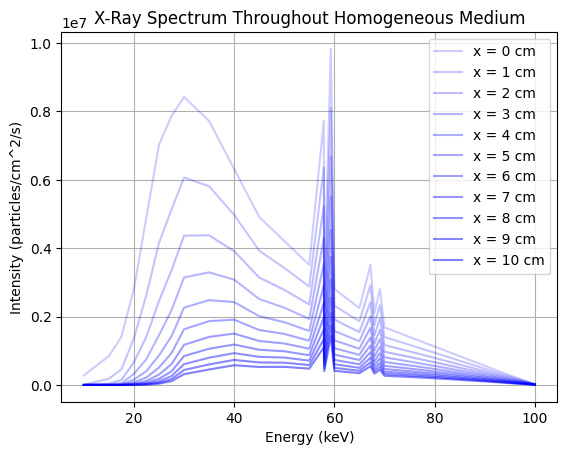

In [187]:
I0 = 10**8 # initial total intensity in particles / cm^2 / s

# initialize the intensity of each energy component of the beam
attenuated_spectrum = {energy: synthetic_spectrum[energy]*I0 for energy in energies}

plt.figure()
for x in range(11): # cm
    I = [attenuated_spectrum[energy] * np.exp(-mu_tot[energy]*x) for energy in energies]
    plt.plot(energies, I, label=f"x = {x} cm", color="blue", alpha=0.2 + 0.6*(x/20))
plt.xlabel("Energy (keV)")
plt.ylabel("Intensity (particles/cm^2/s)")
plt.title("X-Ray Spectrum Throughout Homogeneous Medium")
plt.grid()
plt.legend()
plt.show()

### Beam Hardening

Notice how the lower-energy components of the beam decline in intensity much more rapidly than the higher-energy components. Look at the spectrum at the end of the 10 cm depth.

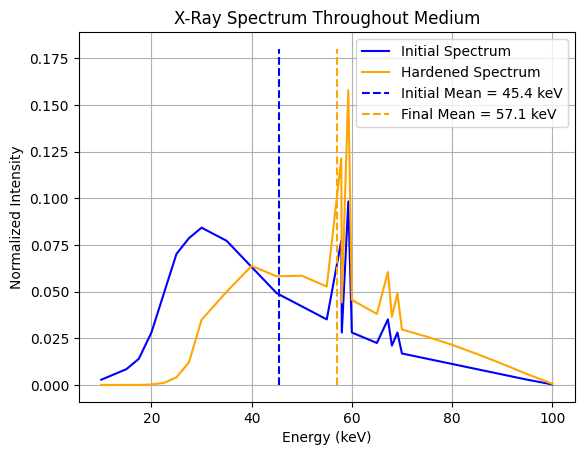

In [88]:
plt.figure()

# initial spectrum
initial_I = list(synthetic_spectrum.values())
plt.plot(energies, initial_I, label="Initial Spectrum", color="blue")

# 10 cm spectrum
final_I = [attenuated_spectrum[energy] * np.exp(-mu_tot[energy]*x) for energy in energies]
# normalize
final_I = [intensity / sum(final_I) for intensity in final_I]
plt.plot(energies, final_I, label=f"Hardened Spectrum", color="orange")

# plot intensity-weighted averages
initial_mean = np.average(list(energies), weights=initial_I)
final_mean = np.average(list(energies), weights=final_I)

# initial spectrum mean energy
plt.vlines(initial_mean, 0, 0.18, label=f"Initial Mean = {round(initial_mean,1)} keV", color="blue", ls="--")

# final spectrum mean energy
plt.vlines(final_mean, 0, 0.18, label=f"Final Mean = {round(final_mean, 1)} keV", color="orange", ls="--")

plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Intensity")
plt.title("X-Ray Spectrum Throughout Medium")
plt.grid()
plt.legend()
plt.show()

This is the phenomenon we call ***beam hardening***. As a polyenergetic X-ray beam passes through an object, lower-energy photons are selectively removed, resulting in a greater average beam energy. This occurs for any absorber material, including water, as we just demonstrated; but the effect is even more pronounced for higher-Z materials, because the photoelectric absorption cross-section is proportional to $Z^{3}$. This is precisely why the original spectrum, having been pre-filtered by tungsten and aluminum, was already missing the very low-energy bremsstrahlung components.

***Note:*** *Unlike photoelectric absorption, the probability of Compton scatter is* not *proportional to Z.*

## X-Ray Detection

### Phantoms

In the clinic, we regularly perform radiation detection experiments for quality assurance (QA). Most of the time, this requires the use of some kind of inanimate object to stand in for human tissue (or medical devices made of different materials, like metal stents). These objects are called **phantoms**. Phantoms come in many shapes, sizes, and materials, with some being very lifelike replications of various examples of human "geometry", and others simply blocks of plastic or metal.

In some QA tests, we stick detectors inside phantoms and irradiate them, resulting in a detected spectrum that mimics what is absorbed inside a body. For imaging QA, there are special phantoms for testing different aspects of image quality; for example, some have sets of increasingly thin engraved lines to test the imager's spatial resolution, and some contain pieces of a variety of materials with different radiological properties to test the imager's contrast.

In the context of computer simulations, a "phantom" is just an array of pixels or voxels (volumetric, i.e., 3D, pixels) with different values corresponding to some material property. A popular example is the Shepp-Logan phantom, which somewhat resembles a brain (gray) inside a skull (white) with a pair of ventricles (fluid-filled, black) and several ellipsoidal masses (lighter gray).

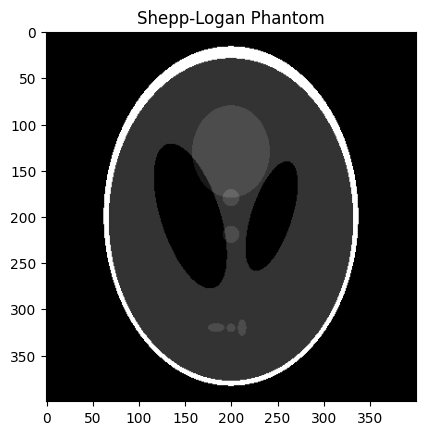

In [184]:
from skimage.data import shepp_logan_phantom

shepp = shepp_logan_phantom()

plt.figure()
plt.imshow(shepp, cmap='gray')
plt.title("Shepp-Logan Phantom")
plt.show()

Let's start with a simpler phantom geometry, like a single tilted ellipse.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
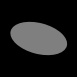

In [168]:
from matplotlib.patches import Ellipse
from PIL import Image
import io

L = 100
center = (L/2, L/2)
minor_axis = 2*L/5
major_axis = 3*L/4
angle = 75 # degrees
angle_rad = np.deg2rad(angle)

ellipse = Ellipse(xy=center, width=minor_axis, height=major_axis, angle=angle, facecolor='gray')

fig, ax = plt.subplots(figsize=(1,1), dpi=100)
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.axis('off')
ax.add_patch(ellipse)

# some magic to turn the plot into an array
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
buf.seek(0)
img = Image.open(buf).convert('L') # convert to grayscale
phantom = 255 - np.array(img)
plt.close(fig)

phantom

Let's irradiate the phantom from the *left* with a monoenergetic beam of $100 \; \text{keV}$ photons, and check the photon count at the rightmost pixel in each row. Then, let's irradiate from the *top* and check the counts at the bottom. Assume that any non-zero pixel value is 100% water. Also assume that our detectors are 100% efficient. What do you think we'll see?

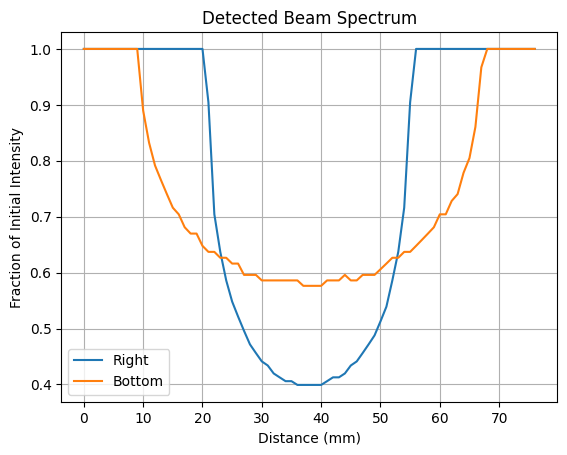

In [170]:
X, Y = phantom.shape # assume 1 mm, or 0.1 cm, per pixel
dx = 0.1 # cm

mu = 0.167 # 1/cm

# convert the grayscale pixel values to a map of attenuation coefficients
mu_phantom = np.zeros((X,Y))
mu_phantom[phantom > 0] = mu

detected_spectrum_right = np.ones(Y)
detected_spectrum_bottom = np.ones(X)

for i in range(X):
    for j in range(Y):
        detected_spectrum_right[i] *= np.exp(-mu_phantom[i,j]*dx)

for j in range(Y):
    for i in range(X):
        detected_spectrum_bottom[j] *= np.exp(-mu_phantom[i,j]*dx)


plt.figure()
plt.plot(detected_spectrum_right, label="Right")
plt.plot(detected_spectrum_bottom, label="Bottom")
plt.xlabel("Distance (mm)")
plt.ylabel("Fraction of Initial Intensity")
plt.title("Detected Beam Spectrum")
plt.grid()
plt.legend()
plt.show()

This pair of signal profiles gives us some non-trivial information about the object being imaged; we could even reason that we are looking at an ellipse. But with only two angles, we do not have enough information to recover the tilt.

Now, what if we add another geometry component inside this simple phantom?

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
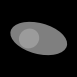

In [173]:
L = 100
center = (L/2, L/2)
minor_axis = 2*L/5
major_axis = 3*L/4
angle = 75 # degrees
angle_rad = np.deg2rad(angle)

ellipse1 = Ellipse(xy=center, width=minor_axis, height=major_axis, angle=angle, facecolor='gray')
ellipse2 = Ellipse(xy=(L/2 - L/8, L/2), width=2*minor_axis/3, height=major_axis/3, angle=angle/2)

fig, ax = plt.subplots(figsize=(1,1), dpi=100)
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.axis('off')
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)

# some magic to turn the plot into an array
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
buf.seek(0)
img = Image.open(buf).convert('L') # convert to grayscale
phantom = 255 - np.array(img)
plt.close(fig)

phantom

This time, let's account for the density dependence of radiological properties of materials. The raw XCOM data we retrieved earlier were actually mass attenuation coefficients, $\Bigl(\frac{\mu}{\rho}\Bigr)$, so they had units of $\text{cm}^{2}\text{/g}$, and we got the linear attenuation coefficients by multiplying them by the density of water, $\rho_{H_{2}O} = 1.0 \;\text{g/cm}^{3}$. Now, where $P_{ij}$ represents the pixel value in the $i,j$-th pixel of the phantom, let the mean *non-zero* pixel value $\bar{P}$ represent 100% of the density of water, and set each pixel value in the attenuation map to $\mu_{ij} = \Bigl(\frac{\mu}{\rho}\Bigr) \cdot (\rho_{H_{2}O}) \cdot \frac{P_{ij}}{\bar{P}}$.

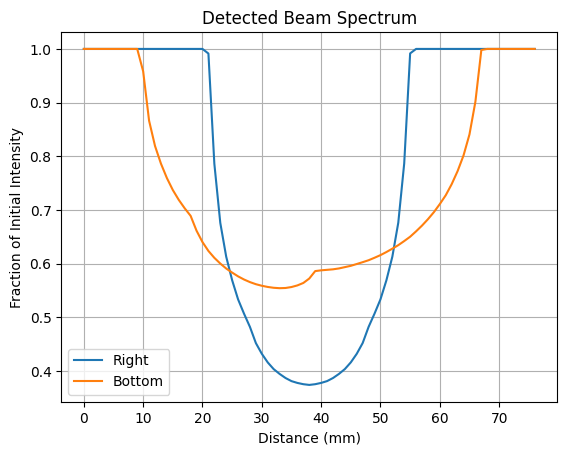

In [183]:
mean_px_val = phantom[phantom > 0].mean()

# convert the grayscale pixel values to a map of attenuation coefficients
mu_phantom = np.zeros((X,Y))
mu_phantom[phantom > 0] = mu * phantom[phantom > 0] / mean_px_val

detected_spectrum_right = np.ones(Y)
detected_spectrum_bottom = np.ones(X)

for i in range(X):
    for j in range(Y):
        detected_spectrum_right[i] *= np.exp(-mu_phantom[i,j]*dx)

for j in range(Y):
    for i in range(X):
        detected_spectrum_bottom[j] *= np.exp(-mu_phantom[i,j]*dx)


plt.figure()
plt.plot(detected_spectrum_right, label="Right")
plt.plot(detected_spectrum_bottom, label="Bottom")
plt.xlabel("Distance (mm)")
plt.ylabel("Fraction of Initial Intensity")
plt.title("Detected Beam Spectrum")
plt.grid()
plt.legend()
plt.show()

This shows that a material inhomogeneity in the imaged object can causes different perturbations to the detector signals at different angles depending on its location, shape, and density. Now let's try the Shepp-Logan phantom, which has far more inhomogeneities!

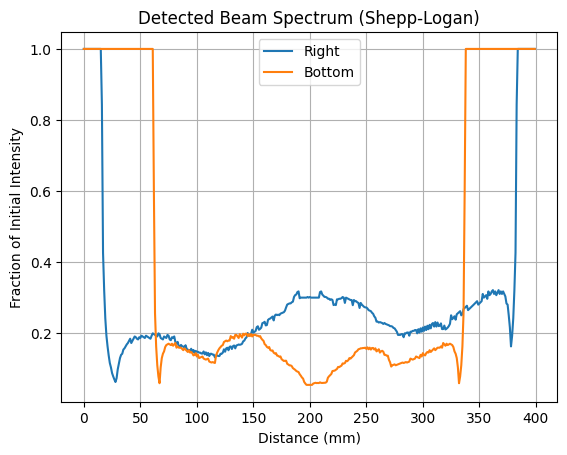

In [186]:
X, Y = shepp.shape # assume 0.5 mm, or 0.05 cm, per pixel
dx = 0.05 # cm

mu = 0.167 # 1/cm

mean_px_val = shepp[shepp > 0].mean()

# convert the grayscale pixel values to a map of attenuation coefficients
mu_phantom = np.zeros((X,Y))
mu_phantom[shepp > 0] = mu * shepp[shepp > 0] / mean_px_val

detected_spectrum_right = np.ones(Y)
detected_spectrum_bottom = np.ones(X)

for i in range(X):
    for j in range(Y):
        detected_spectrum_right[i] *= np.exp(-mu_phantom[i,j]*dx)

for j in range(Y):
    for i in range(X):
        detected_spectrum_bottom[j] *= np.exp(-mu_phantom[i,j]*dx)


plt.figure()
plt.plot(detected_spectrum_right, label="Right")
plt.plot(detected_spectrum_bottom, label="Bottom")
plt.xlabel("Distance (mm)")
plt.ylabel("Fraction of Initial Intensity")
plt.title("Detected Beam Spectrum (Shepp-Logan)")
plt.grid()
plt.legend()
plt.show()

What if we account for a polyenergetic beam?

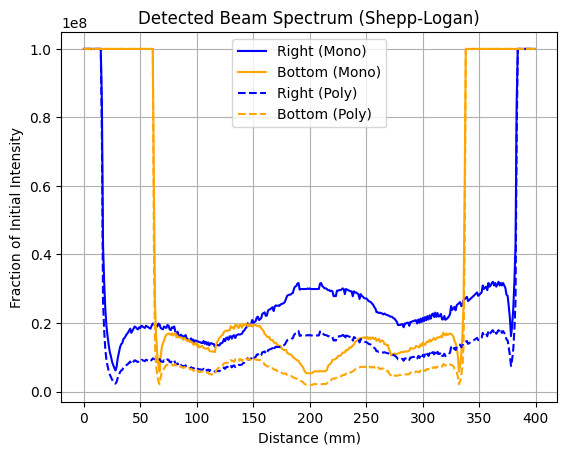

In [204]:
X, Y = shepp.shape # assume 0.5 mm, or 0.05 cm, per pixel
dx = 0.05 # cm

mu = 0.167 # 1/cm

mean_px_val = shepp[shepp > 0].mean()

# convert the grayscale pixel values to a map of density
rho_phantom = np.zeros((X,Y))
rho_phantom[shepp > 0] = shepp[shepp > 0] / mean_px_val

detected_spectrum_right_poly = {energy: synthetic_spectrum[energy]*I0*np.ones(Y) for energy in energies}
for i in range(X):
    for j in range(Y):
        for energy in energies:
            detected_spectrum_right_poly[energy][i] *= np.exp(-rho_phantom[i,j]*mu_tot[energy]*dx)

detected_spectrum_bottom_poly = {energy: synthetic_spectrum[energy]*I0*np.ones(X) for energy in energies}
for j in range(Y):
    for i in range(X):
        for energy in energies:
            detected_spectrum_bottom_poly[energy][j] *= np.exp(-rho_phantom[i,j]*mu_tot[energy]*dx)

# total fluence
detected_spectrum_right_poly = np.sum([counts for counts in detected_spectrum_right_poly.values()], axis=0)
detected_spectrum_bottom_poly = np.sum([counts for counts in detected_spectrum_bottom_poly.values()], axis=0)

plt.figure()
plt.plot(detected_spectrum_right*I0, color="blue", label="Right (Mono)")
plt.plot(detected_spectrum_bottom*I0, color="orange", label="Bottom (Mono)")
plt.plot(detected_spectrum_right_poly, color="blue", ls="--", label="Right (Poly)")
plt.plot(detected_spectrum_bottom_poly, color="orange", ls="--", label="Bottom (Poly)")
plt.xlabel("Distance (mm)")
plt.ylabel("Fraction of Initial Intensity")
plt.title("Detected Beam Spectrum (Shepp-Logan)")
plt.grid()
plt.legend()
plt.show()

As you can see, inhomogeneities in the phantom can have a pretty big impact on the detector counts for polyenergetic (i.e., realistic) X-ray beams.

Using only 2D images and one detector dimension, these results may still seem a bit abstract. In the next notebook, we will look at computed tomography (CT), a method of combining many X-ray images into a single composite one dimension higher than that of the detector. Even with 2D images, it can be helpful to see how this technique makes it possible to fully reconstruct the image (albeit with artifacts) even if they detector signal remains one-dimensional, as it is here.